# Gold Price Forecasting: Multi-Model Deep Learning (Colab Ready)

Well-structured workflow for acquiring gold & macro data, feature engineering, sequence modeling with several neural architectures, and rich evaluation/diagnostics.

## Table of Contents
1. Environment & Imports
2. Runtime / GPU & Reproducibility
3. Data Acquisition – Gold
4. Technical Indicator Engineering
5. Macro / External Data Acquisition
6. Merge & Feature Consolidation
7. Preprocessing & Sequence Construction
8. Model Architectures
   - Regime-Switching Baseline (HMM)
   - CNN→LSTM
   - LSTM→CNN
   - Parallel CNN + LSTM
   - Hybrid Attention (Tech vs Macro)
9. Training Configuration & Fits
10. Evaluation (Scaled)
11. Inversion to Original Scale & Metrics Table
12. Core Prediction Visualizations
13. Residual & Training Diagnostics
14. Advanced / Additional Visualizations
15. Utilities & Next Steps

(Use the section headers to navigate when sharing in Colab.)

In [1]:
# Unified robust imports (auto-install). Run this cell first.
import importlib, subprocess, sys

def ensure_import(import_name, pip_name=None, attr=None):
    """Import a module (or attribute), installing via pip if missing.
    import_name: name used in import
    pip_name: pip package name (defaults to import_name)
    attr: optional attribute to return from module
    """
    try:
        module = importlib.import_module(import_name)
    except ImportError:
        pkg = pip_name or import_name
        print(f"Missing '{import_name}'. Installing '{pkg}' ...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
        module = importlib.import_module(import_name)
    return getattr(module, attr) if attr else module

# Core
yf = ensure_import('yfinance')
pd = ensure_import('pandas')
np = ensure_import('numpy')

# pandas-datareader
ensure_import('pandas_datareader', 'pandas-datareader')
from pandas_datareader import data as web

# scikit-learn (import name 'sklearn')
ensure_import('sklearn', 'scikit-learn')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Visualization
ensure_import('matplotlib')
import matplotlib.pyplot as plt
try:
    sns = ensure_import('seaborn')
except Exception:
    sns = None
    print('Seaborn not available; skipping seaborn-based plots.')

# TensorFlow / Keras
try:
    import tensorflow as tf
except ImportError:
    print('Installing tensorflow...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
    import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from datetime import datetime
import math

print('All core libraries imported successfully.')

2025-08-24 13:49:46.172513: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 13:49:46.588844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ironside/PythonEnvs/dsvenv/lib64/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/ironside/PythonEnvs/dsvenv/lib64/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major ver

All core libraries imported successfully.


In [2]:
# Colab: install dependencies (idempotent)
import sys, subprocess, pkgutil
required = ['yfinance','pandas_datareader','seaborn','tensorflow']
for pkg in required:
    if pkg not in {m.name for m in pkgutil.iter_modules()}:
        print(f'Installing {pkg}...')
        subprocess.check_call([sys.executable,'-m','pip','install',pkg])
print('Dependency check complete.')

Dependency check complete.


## 1. Environment & Imports
Robust import routine with auto-install for missing dependencies (suitable for fresh Colab runtime). Run this first.

In [3]:
# Central configuration (single place to change date range & data interval)
START_DATE = '2010-01-01'   # <-- change here
END_DATE   = '2025-01-01'   # <-- change here
DATA_INTERVAL = '1d'        # <-- change interval if needed ('1h', '1wk', etc.)

from datetime import datetime
start = datetime.fromisoformat(START_DATE)
end   = datetime.fromisoformat(END_DATE)

# Convenience dict for reuse
DATE_KW = dict(start=START_DATE, end=END_DATE)

print(f'Date range configured: {START_DATE} -> {END_DATE} (interval={DATA_INTERVAL})')

Date range configured: 2010-01-01 -> 2025-01-01 (interval=1d)


In [4]:
# GPU check
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('GPUs found:', len(tf.config.list_physical_devices('GPU')))

# Reproducibility seeds
import os, random, numpy as np
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print('Seeds set to', seed)

TensorFlow version: 2.20.0-rc0
GPUs found: 0
Seeds set to 42


2025-08-24 13:49:48.606264: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Runtime / GPU & Reproducibility
Check available GPUs and set deterministic seeds.

In [5]:
# Get historical market data for gold (uses central config)
gold_data = yf.download("GC=F", start=START_DATE, end=END_DATE, interval=DATA_INTERVAL)


/tmp/ipykernel_110670/2798150320.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download("GC=F", start=START_DATE, end=END_DATE, interval=DATA_INTERVAL)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## 3. Data Acquisition – Gold
Download daily gold futures.

## 4. Technical Indicator Engineering
Add key technical indicators (SMA, EMA, RSI, MACD, Bollinger Bands, ATR, Stochastic).

In [6]:
# Technical Indicators - add columns to dataframe
gold_data['SMA_20'] = gold_data['Close'].rolling(window=20).mean()

gold_data['EMA_20'] = gold_data['Close'].ewm(span=20, adjust=False).mean()

# RSI
def rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

gold_data['RSI_14'] = rsi(gold_data['Close'], 14)

# MACD
ema_12 = gold_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = gold_data['Close'].ewm(span=26, adjust=False).mean()
gold_data['MACD'] = ema_12 - ema_26
gold_data['MACD_Signal'] = gold_data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
window = 20
gold_data['BB_Middle'] = gold_data['Close'].rolling(window=window).mean()
gold_data['BB_STD'] = gold_data['Close'].rolling(window=window).std()
gold_data['BB_Upper'] = gold_data['BB_Middle'] + (gold_data['BB_STD'] * 2)
gold_data['BB_Lower'] = gold_data['BB_Middle'] - (gold_data['BB_STD'] * 2)

# ATR
high_low = gold_data['High'] - gold_data['Low']
high_close = (gold_data['High'] - gold_data['Close'].shift()).abs()
low_close = (gold_data['Low'] - gold_data['Close'].shift()).abs()
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
gold_data['ATR'] = true_range.rolling(window=14).mean()

# 3. Stochastic Oscillator (%K and %D)
low_min = gold_data['Low'].rolling(window=14).min()
high_max = gold_data['High'].rolling(window=14).max()
gold_data['%K'] = (gold_data['Close'] - low_min) / (high_max - low_min) * 100
gold_data['%D'] = gold_data['%K'].rolling(window=3).mean()

gold_data.dropna(inplace=True)


In [7]:
gold_data.tail()

Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,BB_Middle,BB_STD,BB_Upper,BB_Lower,ATR,%K,%D
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,2647.054993,2643.143816,44.979194,-9.144972,-3.899556,2647.054993,31.698883,2710.452758,2583.657227,34.842896,24.983464,25.203196
2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,2647.979993,2642.730124,51.858616,-8.295974,-4.778840,2647.979993,31.142093,2710.264178,2585.695807,34.092896,37.376381,27.422510
2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,2646.844995,2640.298679,46.832424,-9.259349,-5.674941,2646.844995,31.857518,2710.560031,2583.129959,33.864328,23.137683,28.499176
2024-12-30,2606.100098,2626.899902,2597.000000,2620.699951,794,2644.300000,2637.041671,40.886580,-10.794069,-6.698767,2644.300000,33.015634,2710.331269,2578.268731,32.692889,15.820704,25.444922
2024-12-31,2629.199951,2629.199951,2604.899902,2608.399902,401,2644.015002,2636.294840,39.073451,-10.030752,-7.365164,2644.015002,33.125467,2710.265937,2577.764068,31.771467,31.048035,23.335474


## 5. Macro / External Data Acquisition
Download DXY, Treasury yields, CPI (FRED), Oil, Silver, S&P 500, Gold ETF holdings.

In [8]:
# USD Index (DXY)
dxy = yf.download("DX-Y.NYB", **DATE_KW)

/tmp/ipykernel_110670/2776273878.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dxy = yf.download("DX-Y.NYB", **DATE_KW)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
# US Treasury Yields (Interest Rates)
tnx = yf.download("^TNX", **DATE_KW)

/tmp/ipykernel_110670/1946396668.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tnx = yf.download("^TNX", **DATE_KW)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
# Inflation Data (CPI)
inflation = web.DataReader('CPIAUCSL', 'fred', start, end)

In [11]:
# Oil Prices WTI
oil = yf.download("CL=F", **DATE_KW)


/tmp/ipykernel_110670/2644539748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil = yf.download("CL=F", **DATE_KW)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
# Silver Prices
silver_data = yf.download("SI=F", **DATE_KW)

/tmp/ipykernel_110670/1988458666.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_data = yf.download("SI=F", **DATE_KW)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
inflation.tail()

,CPIAUCSL
DATE,
2024-09-01,314.851
2024-10-01,315.564
2024-11-01,316.449
2024-12-01,317.603
2025-01-01,319.086


In [14]:
# S&P 500 Index
sp500 = yf.download("^GSPC", **DATE_KW)


/tmp/ipykernel_110670/204985463.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", **DATE_KW)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
# Gold ETF Holdings
gold_etf = yf.download("GLD", **DATE_KW)


/tmp/ipykernel_110670/1739558940.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_etf = yf.download("GLD", **DATE_KW)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [16]:
gold_data['DXY_Close'] = dxy['Close']
gold_data['TNX_Close'] = tnx['Close']
gold_data['Oil_Close'] = oil['Close']
gold_data['SP500_Close'] = sp500['Close']
gold_data['Gold_ETF_Close'] = gold_etf['Close']
gold_data['CPIAUCSL'] = inflation['CPIAUCSL'].reindex(gold_data.index, method='ffill')
gold_data['Silver_Close'] = silver_data['Close']


## 6. Merge & Feature Consolidation
Align macro series with technical indicators and construct full feature dataframe.

In [17]:
gold_data.tail()

Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI_14,MACD,MACD_Signal,...,ATR,%K,%D,DXY_Close,TNX_Close,Oil_Close,SP500_Close,Gold_ETF_Close,CPIAUCSL,Silver_Close
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,2647.054993,2643.143816,44.979194,-9.144972,-3.899556,...,34.842896,24.983464,25.203196,108.260002,4.591,70.099998,6040.040039,241.440002,317.603,29.974001
2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,2647.979993,2642.730124,51.858616,-8.295974,-4.778840,...,34.092896,37.376381,27.422510,108.129997,4.579,69.620003,6037.589844,243.070007,317.603,30.047001
2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,2646.844995,2640.298679,46.832424,-9.259349,-5.674941,...,33.864328,23.137683,28.499176,108.000000,4.619,70.599998,5970.839844,241.399994,317.603,29.655001
2024-12-30,2606.100098,2626.899902,2597.000000,2620.699951,794,2644.300000,2637.041671,40.886580,-10.794069,-6.698767,...,32.692889,15.820704,25.444922,108.129997,4.545,70.989998,5906.939941,240.630005,317.603,29.106001
2024-12-31,2629.199951,2629.199951,2604.899902,2608.399902,401,2644.015002,2636.294840,39.073451,-10.030752,-7.365164,...,31.771467,31.048035,23.335474,108.489998,4.573,71.720001,5881.629883,242.130005,317.603,28.940001


In [18]:
print(gold_data.dtypes)

Price           Ticker
Close           GC=F      float64
High            GC=F      float64
Low             GC=F      float64
Open            GC=F      float64
Volume          GC=F        int64
SMA_20                    float64
EMA_20                    float64
RSI_14                    float64
MACD                      float64
MACD_Signal               float64
BB_Middle                 float64
BB_STD                    float64
BB_Upper                  float64
BB_Lower                  float64
ATR                       float64
%K                        float64
%D                        float64
DXY_Close                 float64
TNX_Close                 float64
Oil_Close                 float64
SP500_Close               float64
Gold_ETF_Close            float64
CPIAUCSL                  float64
Silver_Close              float64
dtype: object


In [19]:
# Flatten MultiIndex Columns
if isinstance(gold_data.columns, pd.MultiIndex):
    gold_data = gold_data.copy()
    gold_data.columns = [
        (f"{lvl0}" if (lvl1 is None or lvl1 == '') else f"{lvl0}_{lvl1}")
        for lvl0, lvl1 in gold_data.columns
    ]

In [20]:
#Preprocessing Data
data = gold_data.copy().dropna()

# Target column (single symbol) - adjust if multi-symbol downloaded
if 'Close_GC=F' in data.columns:
    target_col = 'Close_GC=F'
else:
    target_col = 'Close'

feature_col = data.columns  # All features including target
scalar = MinMaxScaler()
scaled = scalar.fit_transform(data[feature_col])

seq_length = 60  # Past 60 days
horizon = 1     # Predicting the next day

# Define macro feature names
macro_cols = [
    "DXY_Close","TNX_Close","Oil_Close","SP500_Close",
    "Gold_ETF_Close","CPIAUCSL","Silver_Close"
]
macro_cols = [c for c in macro_cols if c in feature_col]
tech_cols = [c for c in feature_col if c not in macro_cols]

tech_idx = [list(feature_col).index(c) for c in tech_cols]
macro_idx = [list(feature_col).index(c) for c in macro_cols]

## 7. Preprocessing & Sequence Construction
Scale features, build sliding window sequences, and split into train/test chronologically.

In [21]:
def make_sequencs(arr, target_index, seq_len=60, horizon=1):
    X, y = [], []
    
    for i in range(seq_len, len(arr)-horizon+1):
        X.append(arr[i-seq_len:i,:])
        y.append(arr[i + horizon -1, target_index])
    return np.array(X), np.array(y)

target_index = list(feature_col).index(target_col)
X, y = make_sequencs(scaled, target_index, seq_length, horizon)

# Train / Test Split (chromological)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2952, 60, 24), (2952,), (739, 60, 24), (739,))

## 8. Model Architectures
### 8.1 CNN → LSTM

In [22]:
# CNN - LSTM

def build_cnn_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    
    #CNN
    x = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inp)
    x = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)
    
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_cnn_lstm = build_cnn_lstm(X_train.shape[1:])
model_cnn_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,113 (195.75 KB)

 Trainable params: 50,113 (195.75 KB)

 Non-trainable params: 0 (0.00 B)

### 8.2 LSTM → CNN

In [23]:
# LSTM - CNN

def build_lstm_cnn(input_shape):
    
    inp = layers.Input(shape=input_shape)
    
    # LSTM
    x = layers.LSTM(units=64, return_sequences=True)(inp)
    x = layers.LSTM(units=64, return_sequences=True)(x)
    # 1D conv across the sequentce of LSTM hidden states
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

model_lstm_cnn = build_lstm_cnn(X_train.shape[1:])
model_lstm_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 60, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Parallel CNN + LSTM

In [24]:
# CNN + LSTM Parallel

def build_parallel_cnn_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    # CNN Branch
    c = layers.Conv1D(64, 3, padding='causal', activation='relu')(inp)
    c = layers.Conv1D(64, 3, padding='causal', activation='relu')(c)
    c = layers.GlobalAveragePooling1D()(c)
    # LSTM Branch
    l = layers.LSTM(64, return_sequences=True)(inp)  # noqa: E741
    l = layers.LSTM(32)(l)  # noqa: E741
    # Merge (correct usage)
    x = layers.Concatenate()([c, l])
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_parallel = build_parallel_cnn_lstm(X_train.shape[1:])
model_parallel.summary()
    
    

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 60, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 60, 64)    │      4,672 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 60, 64)    │     12,352 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60, 64)    │     22,784 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_4[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 32)        │     12,416 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,497 (228.50 KB)

 Trainable params: 58,497 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

### 8.4 Hybrid Attention (Tech vs Macro)

In [25]:
# Hybrid Attention Model (CNN-LSTM branches + temporal attention weighting Technical vs Macro)

def slice_feature_indices(x, indices):
    return tf.gather(x, indices, axis=2)

def temporal_attention(seq_in, name_prefix):
    score = layers.Dense(units=64, activation="tanh", name=f'{name_prefix}_attn_fc')(seq_in)
    score = layers.Dense(units=1, activation=None, name=f'{name_prefix}_attn_score')(score)
    weights = layers.Softmax(axis=1, name=f'{name_prefix}_attn_softmax')(score)
    context = layers.Multiply(name=f'{name_prefix}_attn_weighted')([seq_in, weights])
    context = layers.Lambda(lambda x: K.sum(x, axis=1), name=f'{name_prefix}_attn_context')(context)
    return context, weights


In [26]:
def build_hybrid_attention(input_shape, tech_idx, macro_idx):
    inp =  layers.Input(shape=input_shape)
    tech_slice = layers.Lambda(lambda x: slice_feature_indices(x, tech_idx), name='tech_slice')(inp)
    macro_slice = layers.Lambda(lambda x: slice_feature_indices(x, macro_idx), name='macro_slice')(inp)
    
    # Technical branch
    t = layers.Conv1D(64, 3, padding='causal', activation='relu')(tech_slice)
    t = layers.Conv1D(64, 3, padding='causal', activation='relu')(t)
    t = layers.LSTM(64, return_sequences=True)(t)

    # Macro branch
    m = layers.Conv1D(32, 1, padding='same', activation='relu')(macro_slice)
    m = layers.LSTM(48, return_sequences=True)(m)

    # Attention
    t_ctx, t_w = temporal_attention(t, "tech")
    m_ctx, m_w = temporal_attention(m, "macro")

    concat_ctx = layers.Concatenate(name='ctx_concat')([t_ctx, m_ctx])
    gate = layers.Dense(2, activation='softmax', name='branch_gate')(concat_ctx)

    tech_gate = layers.Lambda(lambda z: z[:, 0:1], name='tech_gate_weight')(gate)
    macro_gate = layers.Lambda(lambda z: z[:, 1:2], name='macro_gate_weight')(gate)

    # FIX: use layers.Multiply() correctly
    t_ctx_g = layers.Multiply(name='tech_gate_apply')([t_ctx, tech_gate])
    m_ctx_g = layers.Multiply(name='macro_gate_apply')([m_ctx, macro_gate])

    fused = layers.Concatenate(name='fused_concat')([t_ctx_g, m_ctx_g, concat_ctx])
    fused = layers.Dense(128, activation='relu')(fused)
    fused = layers.Dropout(0.3)(fused)
    out = layers.Dense(1, activation='linear')(fused)

    model = keras.Model(inputs=inp, outputs=out, name='hybrid_attention_model')
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_hybrid_attn = build_hybrid_attention(X_train.shape[1:], tech_idx, macro_idx)
model_hybrid_attn.summary()

Model: "hybrid_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 60, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_slice (Lambda) │ (None, 60, 17)    │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 60, 64)    │      3,328 │ tech_slice[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macro_slice         │ (None, 60, 7)     │          0 │ input_layer_3[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 60, 64)    │     12,352 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 60, 32)    │        256 │ macro_slice[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 60, 64)    │     33,024 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 60, 48)    │     15,552 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_attn_fc        │ (None, 60, 64)    │      4,160 │ lstm_5[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macro_attn_fc       │ (None, 60, 64)    │      3,136 │ lstm_6[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_attn_score     │ (None, 60, 1)     │         65 │ tech_attn_fc[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macro_attn_score    │ (None, 60, 1)     │         65 │ macro_attn_fc[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_attn_softmax   │ (None, 60, 1)     │          0 │ tech_attn_score[… │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macro_attn_softmax  │ (None, 60, 1)     │          0 │ macro_attn_score… │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_attn_weighted  │ (None, 60, 64)    │          0 │ lstm_5[0][0],     │
│ (Multiply)          │                   │            │ tech_attn_softma… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macro_attn_weighted │ (None, 60, 48)    │          0 │ lstm_6[0][0],     │
│ (Multiply)          │                   │            │ macro_attn_softm… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_attn_context   │ (None, 64)        │          0 │ tech_attn_weight… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ macro_attn_context  │ (None, 48)        │          0 │ macro_attn_weigh… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_concat          │ (None, 112)       │          0 │ tech_attn_contex

 Total params: 101,093 (394.89 KB)

 Trainable params: 101,093 (394.89 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Training Configuration & Fits

In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-5)
]

batch_size = 64
epochs = 50

In [28]:
# CNN - LSTM Model Run
hist_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0127 - mae: 0.0740 - val_loss: 0.0027 - val_mae: 0.0487 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0127 - mae: 0.0740 - val_loss: 0.0027 - val_mae: 0.0487 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - mae: 0.0289 - val_loss: 9.4963e-04 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - mae: 0.0289 - val_loss: 9.4963e-04 - val_mae: 0.0265 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - mae: 0.0251 - val_loss: 7.0140e-04 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - mae: 0.0251 - val_loss: 7.0140e-04 - val_mae: 0.0221 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.8612e-04 - mae: 0.0225 - val_loss: 0.0010 - val_mae: 0.0288 - learning_rate: 

In [29]:
# LSTM - CNN Model Run
hist_lstm_cnn = model_lstm_cnn.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0071 - mae: 0.0583 - val_loss: 0.0012 - val_mae: 0.0282 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0071 - mae: 0.0583 - val_loss: 0.0012 - val_mae: 0.0282 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - mae: 0.0355 - val_loss: 0.0010 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - mae: 0.0355 - val_loss: 0.0010 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0020 - mae: 0.0332 - val_loss: 9.9563e-04 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0020 - mae: 0.0332 - val_loss: 9.9563e-04 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0018 - mae: 0.0310 - val_loss: 0.0016 - val_mae: 0.0335 - learning_rate: 0.0010
Epoch

In [30]:
#  CNN + LSTM Parallel Model Run
hist_cnn_lstm_parallel = model_parallel.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0083 - mae: 0.0603 - val_loss: 0.0011 - val_mae: 0.0294 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0083 - mae: 0.0603 - val_loss: 0.0011 - val_mae: 0.0294 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - mae: 0.0310 - val_loss: 0.0017 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - mae: 0.0310 - val_loss: 0.0017 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - mae: 0.0286 - val_loss: 3.2902e-04 - val_mae: 0.0148 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - mae: 0.0286 - val_loss: 3.2902e-04 - val_mae: 0.0148 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 3.2877e-04 - val_mae: 0.0148 - learning_rate: 0.0010
E

In [31]:
# hybrid_attention_model_run
hist_hybrid_attn = model_hybrid_attn.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0061 - mae: 0.0562 - val_loss: 9.6092e-04 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0061 - mae: 0.0562 - val_loss: 9.6092e-04 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0017 - mae: 0.0299 - val_loss: 0.0013 - val_mae: 0.0290 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0017 - mae: 0.0299 - val_loss: 0.0013 - val_mae: 0.0290 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 8.3207e-04 - val_mae: 0.0230 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 8.3207e-04 - val_mae: 0.0230 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0015 - mae: 0.0280 - val_loss: 9.0076e-04 - val_mae: 0.0238 - learning_rate: 

## 10. Evaluation (Scaled)

In [32]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    rmse_train = math.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = math.sqrt(mean_squared_error(y_test, pred_test))
    mae_test = mean_absolute_error(y_test, pred_test)
    
    print(f'{name} - Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}, Test MAE: {mae_test:.4f}')
    

In [33]:
evaluate_model(model_cnn_lstm, X_train, y_train, X_test, y_test, "CNN-LSTM")
evaluate_model(model_lstm_cnn, X_train, y_train, X_test, y_test, "LSTM-CNN")
evaluate_model(model_parallel, X_train, y_train, X_test, y_test, "Parallel")
evaluate_model(model_hybrid_attn, X_train, y_train, X_test, y_test, "Hybrid Attention")

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
CNN-LSTM - Train RMSE: 0.0141, Test RMSE: 0.0756, Test MAE: 0.0652
CNN-LSTM - Train RMSE: 0.0141, Test RMSE: 0.0756, Test MAE: 0.0652
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM-CNN - Train RMSE: 0.0354, Test RMSE: 0.1735, Test MAE: 0.1547
LSTM-CNN - Train RMSE: 0.0354, Test RMSE: 0.1735, Test MAE: 0.1547
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Parallel - Train RMSE: 0.0197, Test RMSE: 0.1315, Test MAE: 0.1077
Parallel - Train RMSE: 0.0197, Test RMSE: 0.1315, Test MAE: 0.1077
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Hybrid At

## 11. Inversion to Original Scale & Metrics

In [34]:
def invert_scaled_vectors(pred_scaled, true_scaled, scaler_obj, feature_cols, tgt_idx):
    # Build placeholder arrays to inverse transform only target
    inv_pred_vecs = []
    inv_true_vecs = []
    for p, t in zip(pred_scaled, true_scaled):
        temp_p = np.zeros(len(feature_cols))
        temp_p[tgt_idx] = p
        inv_pred_vecs.append(temp_p)
        temp_t = np.zeros(len(feature_cols))
        temp_t[tgt_idx] = t
        inv_true_vecs.append(temp_t)
    inv_pred = scaler_obj.inverse_transform(np.array(inv_pred_vecs))[:, tgt_idx]
    inv_true = scaler_obj.inverse_transform(np.array(inv_true_vecs))[:, tgt_idx]
    return inv_pred, inv_true

In [35]:
results = []
models = [
    ("CNN-LSTM", model_cnn_lstm),
    ("LSTM-CNN", model_lstm_cnn),
    ("Parallel", model_parallel),
    ("Hybrid Attention", model_hybrid_attn)
]


### Regime-Switching Baseline (HMM)
A 2-state Gaussian Hidden Markov Model on daily returns provides an interpretable, non-neural comparator. We fit it on training returns and generate a test price path via expected returns.

In [36]:
for name, mdl in models:
    pred_scaled = mdl.predict(X_test, verbose=0).ravel()
    inv_pred, inv_true = invert_scaled_vectors(pred_scaled, y_test, scalar, feature_col, target_index)
    rmse = math.sqrt(mean_squared_error(inv_true, inv_pred))
    mae = mean_absolute_error(inv_true, inv_pred)
    results.append((name, rmse, mae))
    print(f"{name} (original scale) -> RMSE: {rmse:.4f}, MAE: {mae:.4f}")

best = min(results, key=lambda x: x[1])[0]
print("Best (by RMSE):", best)

CNN-LSTM (original scale) -> RMSE: 131.4309, MAE: 113.3622
LSTM-CNN (original scale) -> RMSE: 301.5629, MAE: 268.8630
LSTM-CNN (original scale) -> RMSE: 301.5629, MAE: 268.8630
Parallel (original scale) -> RMSE: 228.5334, MAE: 187.1092
Hybrid Attention (original scale) -> RMSE: 197.3656, MAE: 161.7294
Best (by RMSE): CNN-LSTM
Parallel (original scale) -> RMSE: 228.5334, MAE: 187.1092
Hybrid Attention (original scale) -> RMSE: 197.3656, MAE: 161.7294
Best (by RMSE): CNN-LSTM


In [37]:
# Assemble predictions for each model
preds_df = []
model_objs = {
    "CNN-LSTM": model_cnn_lstm,
    "LSTM-CNN": model_lstm_cnn,
    "Parallel": model_parallel,
    "Hybrid Attention": model_hybrid_attn
}

In [38]:
# Rebuild target date index aligned with sequences
all_target_index = data.index[seq_length:]
test_target_index = all_target_index[split:]

In [ ]:
# Fit Regime-Switching HMM baseline (uses START_DATE/END_DATE configured earlier)
import numpy as np, pandas as pd

# Choose price column
_possible_cols = ['Close','Adj Close','close','adj_close','Price','price']
_price_col = next((c for c in _possible_cols if c in gold_data.columns), None)
if _price_col is None:
    _price_col = gold_data.select_dtypes(include='number').columns[0]
_prices = gold_data[_price_col].astype(float).sort_index()
_rets = _prices.pct_change().dropna()

# Use same split index already defined
if isinstance(split, int):
    _split_date = _prices.index[split]
else:
    _split_date = pd.to_datetime(split)
_train_ret = _rets.loc[_rets.index < _split_date]
_test_ret  = _rets.loc[_rets.index >= _split_date]

try:
    from hmmlearn.hmm import GaussianHMM as _GHMM
    _hmm = _GHMM(n_components=2, covariance_type='diag', n_iter=200, random_state=seed)
    _hmm.fit(_train_ret.to_frame())
    _post_train = _hmm.predict_proba(_train_ret.to_frame())
    _post_test  = _hmm.predict_proba(_test_ret.to_frame())
    _means = _hmm.means_.ravel()
except Exception:
    # Light fallback EM
    x = _train_ret.values.reshape(-1,1)
    _means = np.array([x.mean()-x.std(), x.mean()+x.std()])
    _vars = np.array([x.var(), x.var()])
    _trans = np.array([[0.95,0.05],[0.05,0.95]])
    _pi = np.array([0.5,0.5])
    def _gpdf(v,m,s2):
        return (1/np.sqrt(2*np.pi*s2))*np.exp(-0.5*(v-m)**2/s2)
    for _ in range(80):
        B = np.column_stack([_gpdf(x,_means[k],_vars[k]) for k in range(2)])
        a = np.zeros_like(B); a[0]=_pi*B[0]; a[0]/=a[0].sum()
        for t in range(1,len(x)):
            a[t] = (a[t-1] @ _trans) * B[t]; s=a[t].sum(); a[t]/=s if s else 1
        b = np.zeros_like(B); b[-1]=1
        for t in range(len(x)-2,-1,-1):
            b[t] = (_trans @ (B[t+1]*b[t+1])); s=b[t].sum(); b[t]/=s if s else 1
        g = a*b; g/=g.sum(axis=1, keepdims=True)
        xi_sum = np.zeros((2,2))
        for t in range(len(x)-1):
            denom = (a[t][:,None]*_trans*(B[t+1]*b[t+1])[None,:]).sum()
            if denom==0: continue
            xi = (a[t][:,None]*_trans*(B[t+1]*b[t+1])[None,:]) / denom
            xi_sum += xi
        _pi = g[0]; _trans = xi_sum / xi_sum.sum(axis=1, keepdims=True)
        for k in range(2):
            w = g[:,k]; _means[k] = (w*x.ravel()).sum()/w.sum(); _vars[k] = (w*(x.ravel()-_means[k])**2).sum()/w.sum()
    _post_train = g
    xt = _test_ret.values.reshape(-1,1)
    B2 = np.column_stack([_gpdf(xt,_means[k],_vars[k]) for k in range(2)])
    filt = np.zeros_like(B2); filt[0]=(_post_train[-1] @ _trans)*B2[0]; filt[0]/=filt[0].sum()
    for t in range(1,len(xt)):
        filt[t] = (filt[t-1] @ _trans)*B2[t]; s=filt[t].sum(); filt[t]/=s if s else 1
    _post_test = filt

_post_all = np.vstack([_post_train, _post_test])
_ret_index = _rets.index[1:]
if _post_all.shape[0] != len(_ret_index):
    m = min(_post_all.shape[0], len(_ret_index)); _post_all = _post_all[-m:]; _ret_index = _ret_index[-m:]
_exp_ret = (_post_all * _means).sum(axis=1)
_exp_ret_series = pd.Series(_exp_ret, index=_ret_index, name='RegimeExpReturn')
_last_train_price = _prices.loc[_prices.index < _split_date].iloc[-1]
_forecast_prices = [_last_train_price]
for r in _exp_ret_series.loc[_exp_ret_series.index >= _split_date]:
    _forecast_prices.append(_forecast_prices[-1]*(1+r))
_regime_forecast = pd.Series(_forecast_prices[1:], index=_exp_ret_series.loc[_exp_ret_series.index >= _split_date].index, name='RegimeSwitch')
_actual_test_prices = _prices.loc[_prices.index >= _split_date]
_ci = _actual_test_prices.index.intersection(_regime_forecast.index)
_regime_rmse = float(np.sqrt(((_regime_forecast.loc[_ci]-_actual_test_prices.loc[_ci])**2).mean()))
_regime_mae  = float((_regime_forecast.loc[_ci]-_actual_test_prices.loc[_ci]).abs().mean())
print(f"Regime-Switching Baseline ({_price_col}) RMSE: {_regime_rmse:.4f} MAE: {_regime_mae:.4f}")

# Save for later usage
model_objs['RegimeSwitch'] = {'means':_means,'forecast':_regime_forecast,'expected_returns':_exp_ret_series,'price_col':_price_col}


In [39]:
def invert_only_target(pred_scaled_vec, true_scaled_vec):
    inv_pred, inv_true = invert_scaled_vectors(
        pred_scaled_vec,
        true_scaled_vec,
        scalar,          # scaler object
        feature_col,     # all feature column names
        target_index     # integer index of target in scaled array
    )
    return inv_pred, inv_true

In [ ]:
actual_inv = None
for name, mdl in model_objs.items():
    if name == 'RegimeSwitch':
        # Regime model already in original price scale; align index later
        continue
    p_Scaled = mdl.predict(X_test, verbose=0).ravel()
    p_inv, t_inv = invert_only_target(p_Scaled, y_test)
    if actual_inv is None:
        actual_inv = t_inv
    preds_df.append(pd.Series(p_inv, name=name, index=test_target_index))

# Add regime forecast aligned to test_target_index (reindex & interpolate if needed)
if 'RegimeSwitch' in model_objs:
    reg_fore = model_objs['RegimeSwitch']['forecast']
    reg_aligned = reg_fore.reindex(test_target_index).interpolate()
    preds_df.append(pd.Series(reg_aligned.values, name='RegimeSwitch', index=test_target_index))

preds_df = pd.concat(preds_df, axis=1)
preds_df.insert(0, "Actual", actual_inv)

display(preds_df.head())

,Actual,CNN-LSTM,LSTM-CNN,Parallel,Hybrid Attention
Date,,,,,
2022-01-24,1841.699951,1802.231566,1776.375468,1805.315459,1797.044375
2022-01-25,1852.699951,1810.006526,1775.912436,1810.181567,1797.470275
2022-01-26,1829.900024,1813.699078,1775.616937,1814.887393,1797.816009
2022-01-27,1793.300049,1813.830618,1775.690993,1817.473920,1798.683760
2022-01-28,1784.900024,1812.451931,1776.021604,1814.625556,1799.669120


In [ ]:
# Compute metrics summary table
metric_rows = []

for name in ["CNN-LSTM", "LSTM-CNN", "Parallel", "Hybrid Attention", "RegimeSwitch"]:
    if name not in preds_df.columns:  # skip if missing
        continue
    rmse = math.sqrt(mean_squared_error(preds_df["Actual"], preds_df[name]))
    mae = mean_absolute_error(preds_df["Actual"], preds_df[name])
    metric_rows.append({"Model": name, "RMSE": rmse, "MAE": mae})
    
metrics_df = pd.DataFrame(metric_rows, columns=["Model", "RMSE", "MAE"]).set_index("Model")
display(metrics_df)

,RMSE,MAE
Model,,
CNN-LSTM,131.430938,113.362208
LSTM-CNN,301.562914,268.863000
Parallel,228.533432,187.109243
Hybrid Attention,197.365622,161.729359


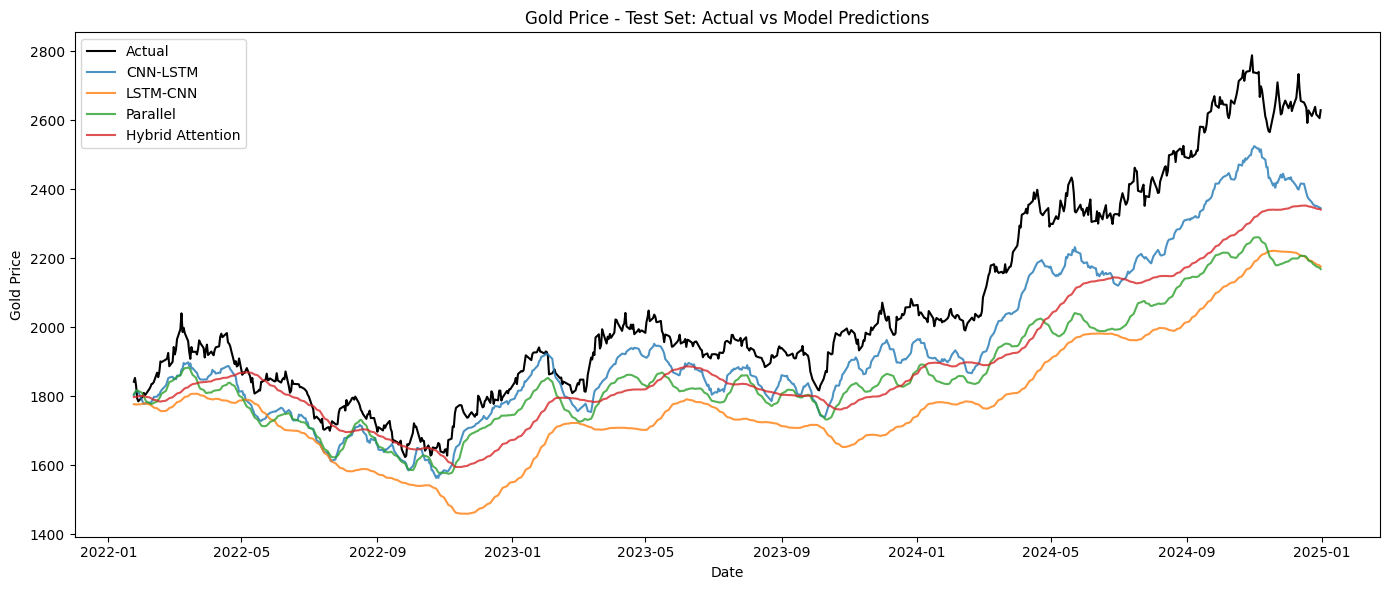

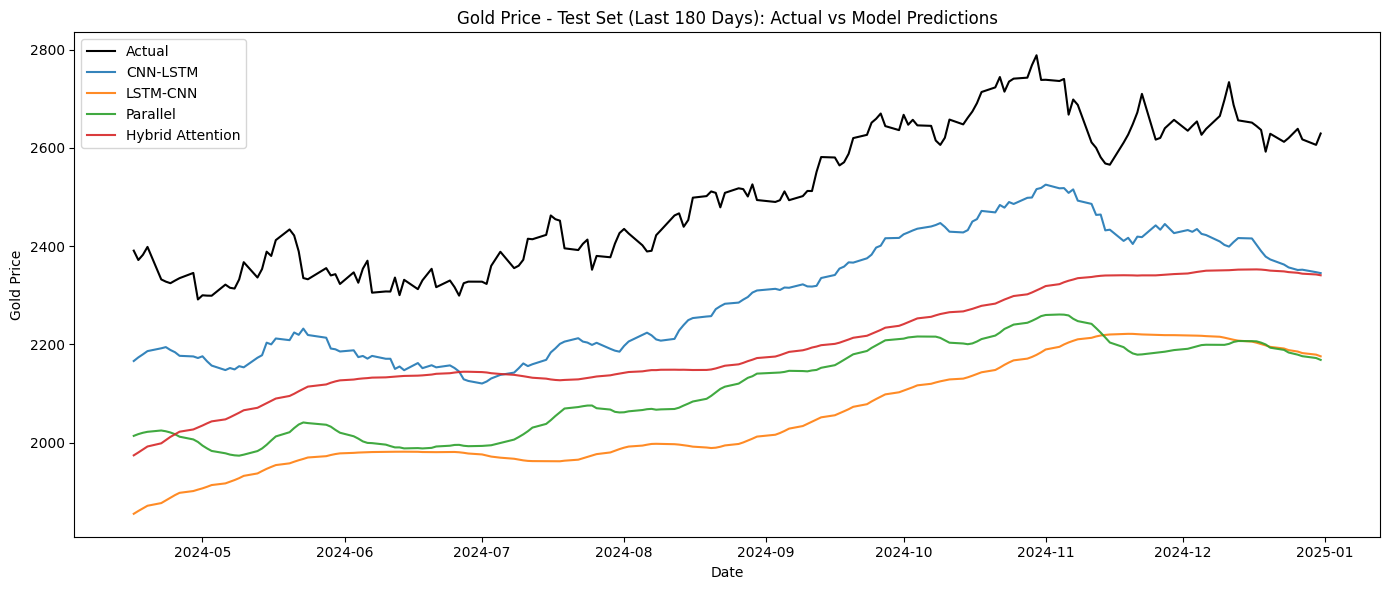

In [ ]:
# Plot: Actual Vs Predictions (full test span)
plt.figure(figsize=(14,6))
plt.plot(preds_df.index, preds_df["Actual"], label="Actual", color='black', linewidth=1.5)
for name in ["CNN-LSTM", "LSTM-CNN", "Parallel", "Hybrid Attention", "RegimeSwitch"]:
    if name in preds_df.columns:
        plt.plot(preds_df.index, preds_df[name], label=name, alpha=0.8)
plt.title("Gold Price - Test Set: Actual vs Model Predictions")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.tight_layout()
plt.show()

# Zoom last 180 days
plt.figure(figsize=(14,6))
last_n = 180
subset = preds_df.iloc[-last_n:]
plt.plot(subset.index, subset["Actual"], label="Actual", color='black', linewidth=1.5)
for name in ["CNN-LSTM", "LSTM-CNN", "Parallel", "Hybrid Attention", "RegimeSwitch"]:
    if name in subset.columns:
        plt.plot(subset.index, subset[name], label=name, alpha=0.9)
plt.title(f"Gold Price - Test Set (Last {last_n} Days): Actual vs Model Predictions")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.tight_layout()
plt.show()

## 12. Core Prediction Visualizations

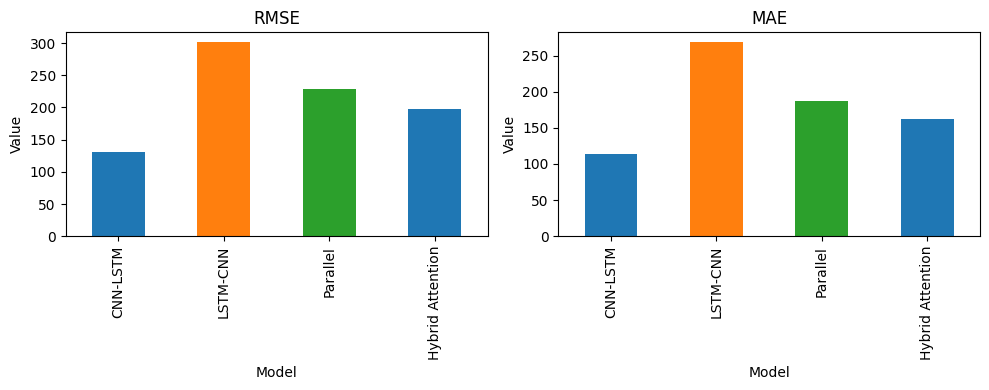

In [ ]:
# Bar Chart: RMSE / MAE
fig, ax = plt.subplots(1,2, figsize=(10,4))
metrics_df["RMSE"].plot(kind="bar", ax=ax[0], color="#1f77b4")
ax[0].set_title("RMSE")
ax[0].set_ylabel("Value")
metrics_df["MAE"].plot(kind="bar", ax=ax[1], color="#ff7f0e")
ax[1].set_title("MAE")
ax[1].set_ylabel("Value")
plt.tight_layout()
plt.show()

## 13. Residual & Training Diagnostics

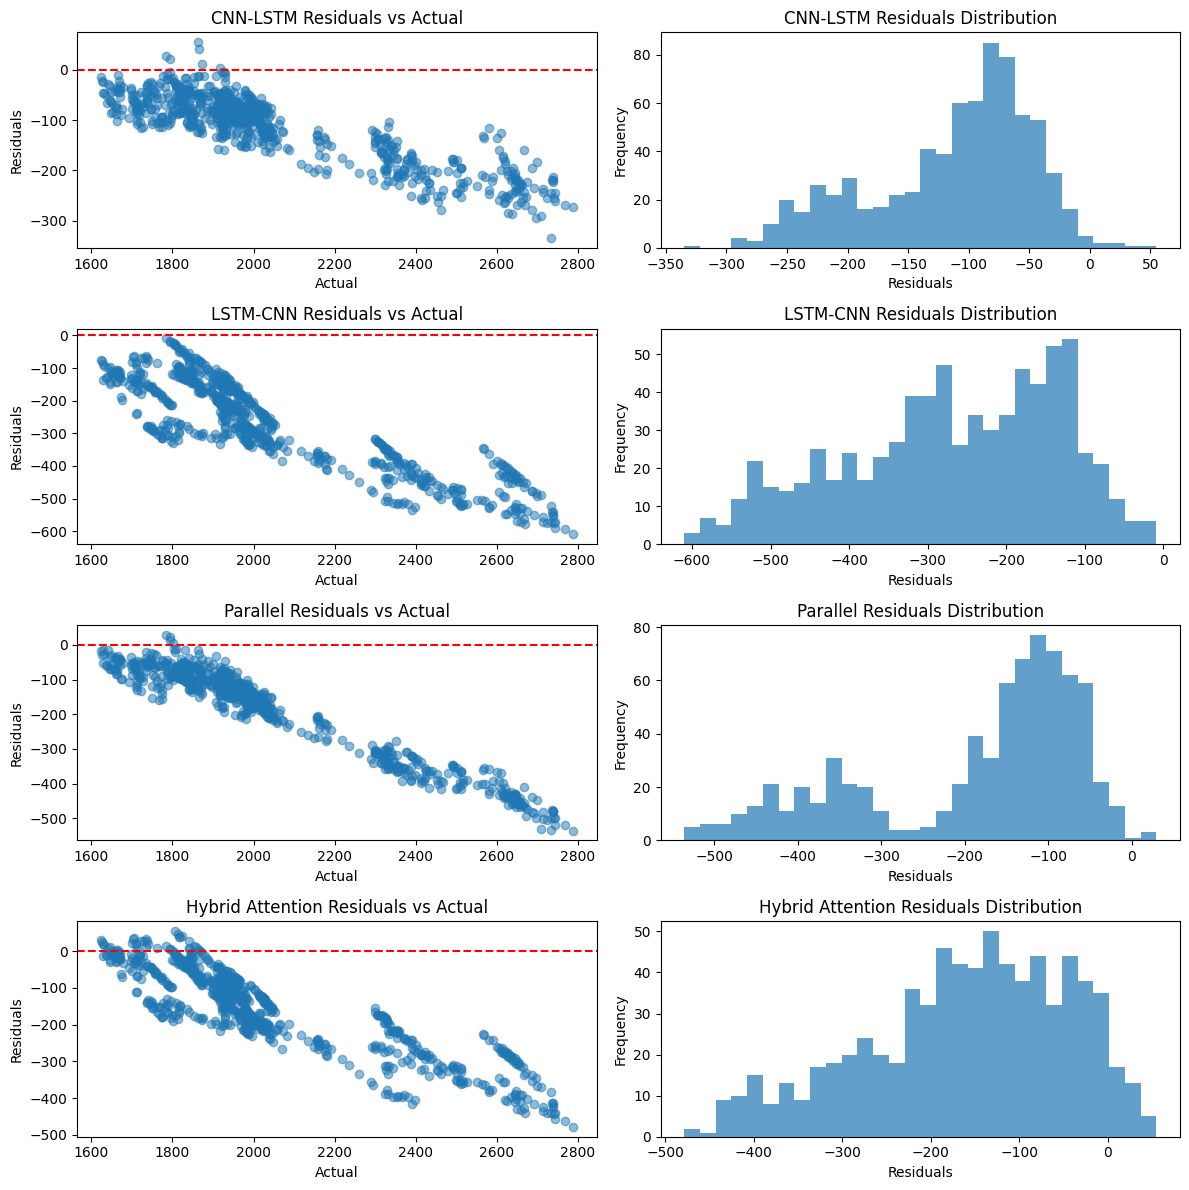

In [ ]:
# Residual plots
fig, axes = plt.subplots(5,2, figsize=(12,14))
model_list = [m for m in ["CNN-LSTM","LSTM-CNN","Parallel","Hybrid Attention","RegimeSwitch"] if m in preds_df.columns]
for i, name in enumerate(model_list):
    residuals = preds_df[name] - preds_df["Actual"]
    axes[i,0].scatter(preds_df["Actual"], residuals, alpha=0.5)
    axes[i,0].axhline(0, color='red', linestyle='--')
    axes[i,0].set_title(f"{name} Residuals vs Actual")
    axes[i,0].set_xlabel("Actual")
    axes[i,0].set_ylabel("Residuals")
    axes[i,1].hist(residuals, bins=30, alpha=0.7)
    axes[i,1].set_title(f"{name} Residuals Distribution")
    axes[i,1].set_xlabel("Residuals")
    axes[i,1].set_ylabel("Frequency")
# Hide unused subplots if any
for j in range(len(model_list), 5):
    axes[j,0].axis('off'); axes[j,1].axis('off')
plt.tight_layout()
plt.show()

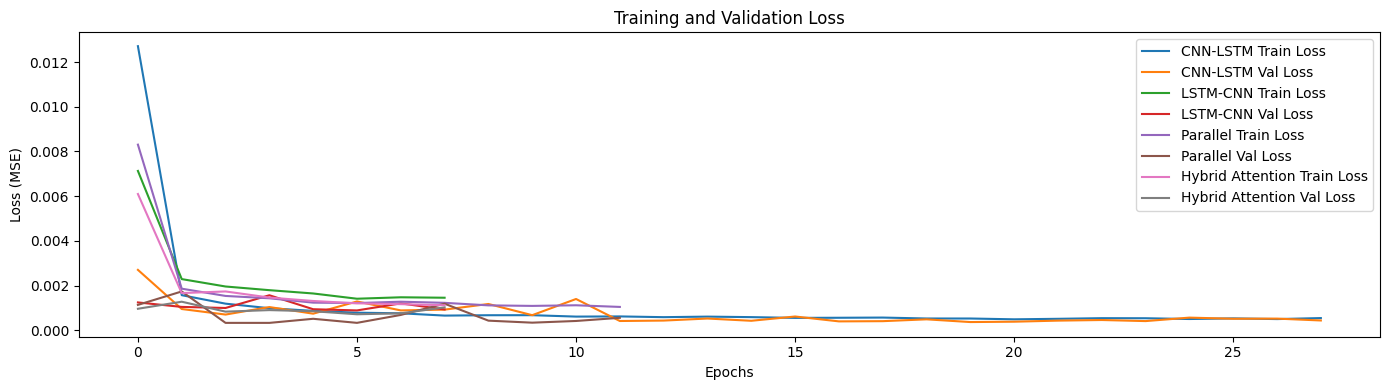

In [45]:
# Training curves (loss & val_loss)
plt.figure(figsize=(14,4))
def plot_hist(h, label):
    plt.plot(h.history['loss'], label=f'{label} Train Loss')
    plt.plot(h.history['val_loss'], label=f'{label} Val Loss')
    
plot_hist(hist_cnn_lstm, "CNN-LSTM")
plot_hist(hist_lstm_cnn, "LSTM-CNN")
plot_hist(hist_cnn_lstm_parallel, "Parallel")
plot_hist(hist_hybrid_attn, "Hybrid Attention")

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.show()

## 14. Advanced / Additional Visualizations

The following cells add richer diagnostic and exploratory plots:

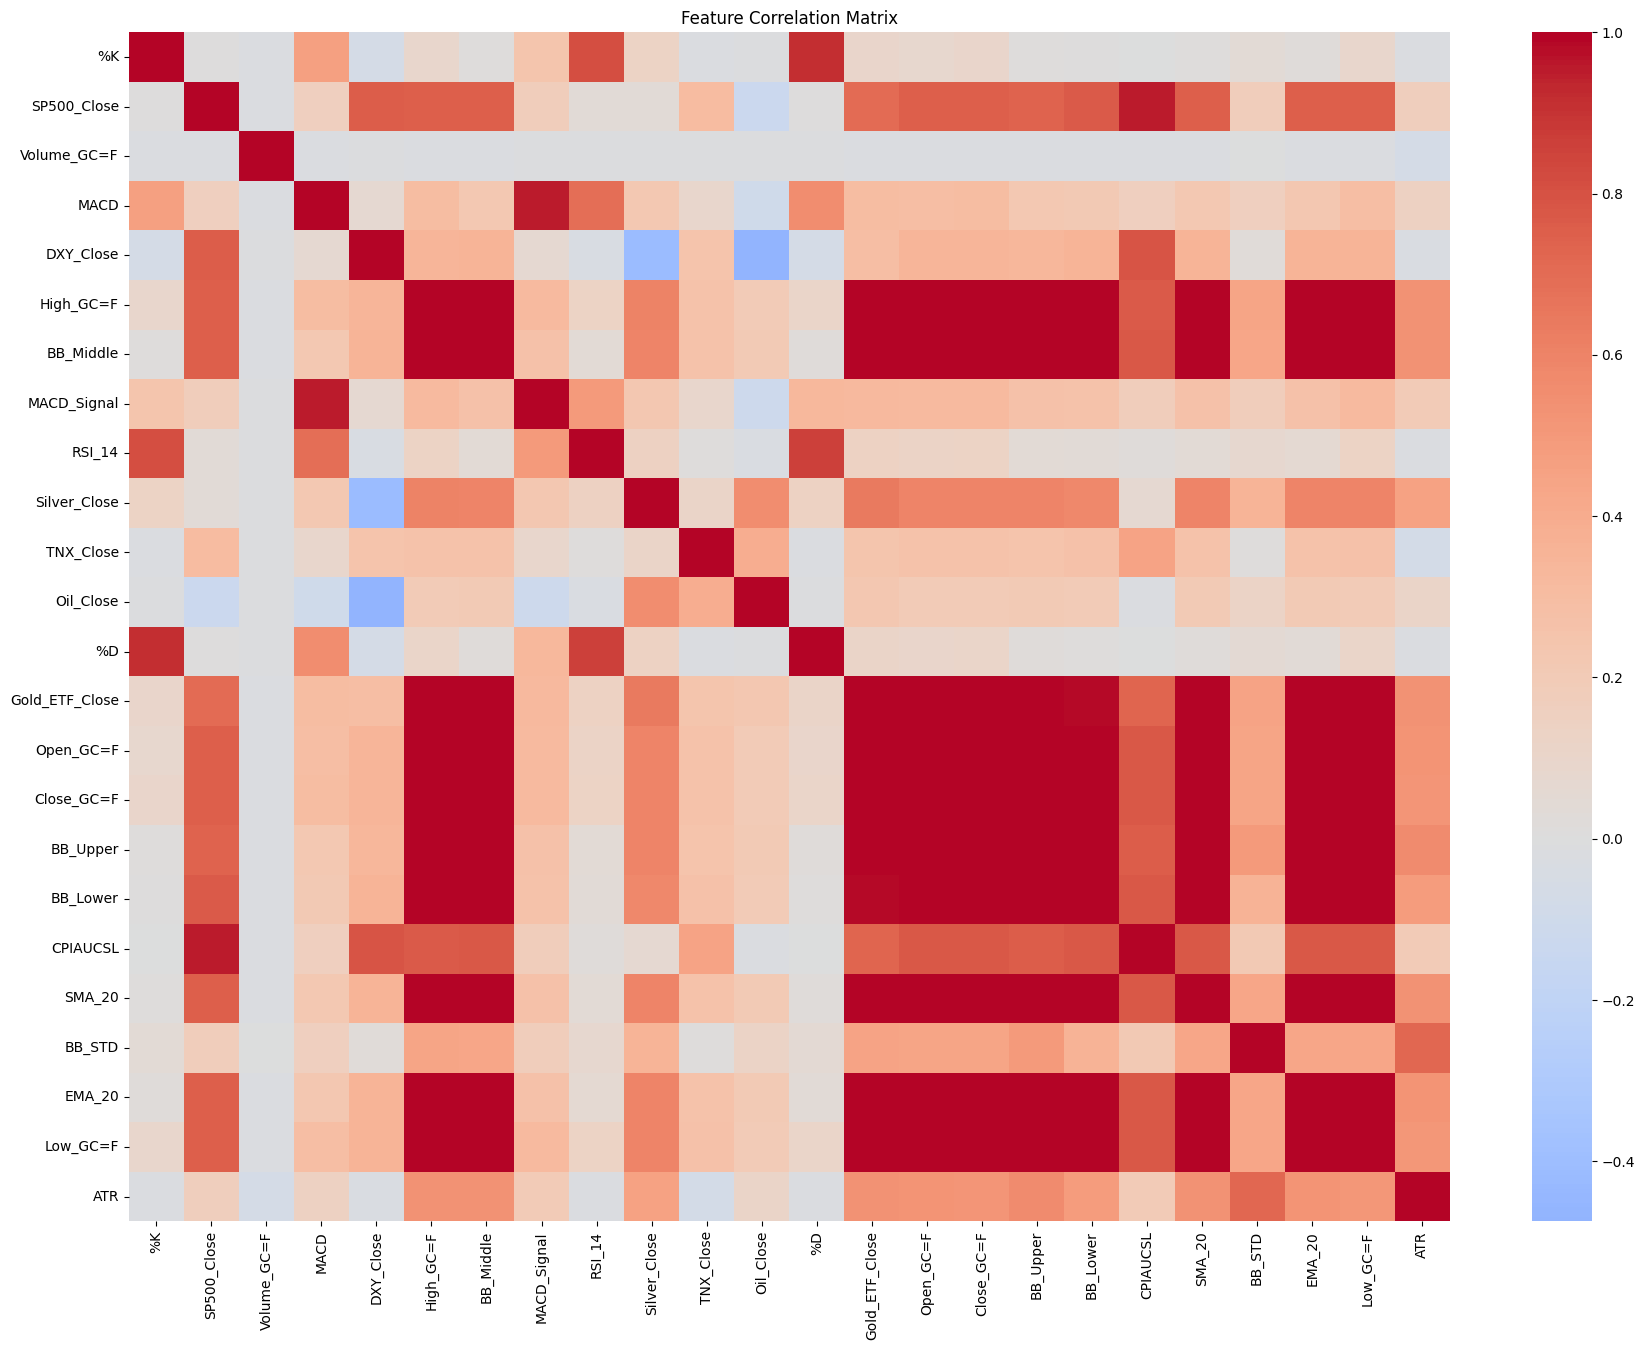

In [46]:
# 1. Correlation heatmap (technical + macro features)
import seaborn as sns
import matplotlib.pyplot as plt

feature_cols_for_corr = list(set(tech_cols + macro_cols + [target_col]))
subset_corr = gold_data[feature_cols_for_corr].dropna().copy()
plt.figure(figsize=(min(0.8*len(feature_cols_for_corr)+4, 18), 0.4*len(feature_cols_for_corr)+4))
corr = subset_corr.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

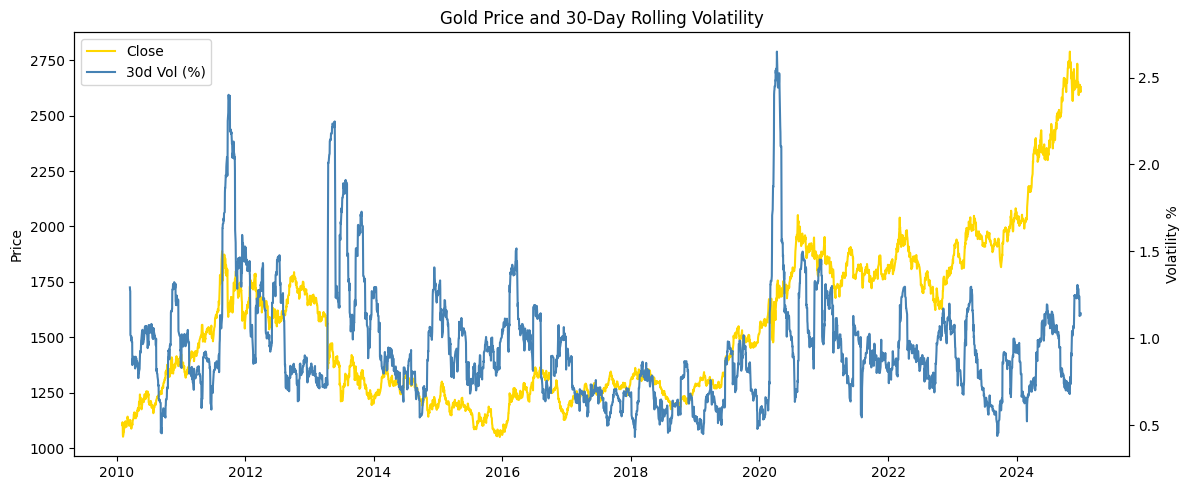

In [47]:
# 2. Rolling volatility vs price
roll_win = 30  # days
returns = gold_data[target_col].pct_change()
vol = returns.rolling(roll_win).std() * 100
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(gold_data.index, gold_data[target_col], color='gold', label='Close')
ax1.set_ylabel('Price')
ax2 = ax1.twinx()
ax2.plot(vol.index, vol, color='steelblue', label=f'{roll_win}d Vol (%)')
ax2.set_ylabel('Volatility %')
ax1.set_title(f'Gold Price and {roll_win}-Day Rolling Volatility')
lns1, labs1 = ax1.get_legend_handles_labels()
lns2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lns1+lns2, labs1+labs2, loc='upper left')
plt.tight_layout()
plt.show()

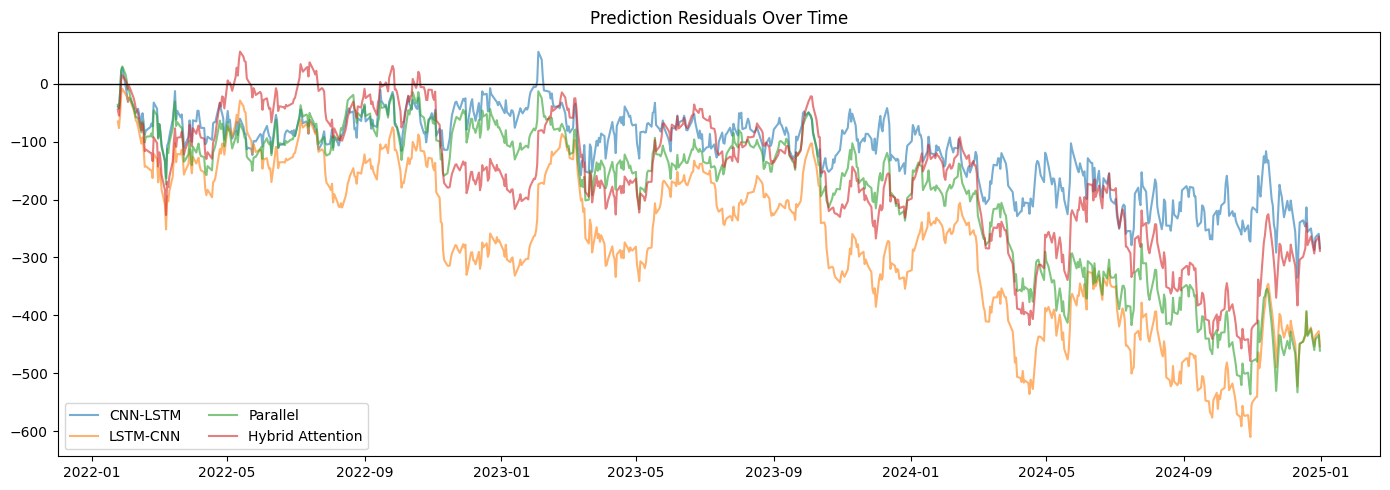

In [48]:
# 3. Residuals over time per model
if 'preds_df' in globals():
    err_df = preds_df.copy()
    model_cols = [c for c in preds_df.columns if c not in ['Actual']]
    plt.figure(figsize=(14,5))
    for m in model_cols:
        err = err_df[m] - err_df['Actual']
        plt.plot(err_df.index, err, label=m, alpha=0.6)
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Prediction Residuals Over Time')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()
else:
    print('preds_df not found; run prediction cells first.')

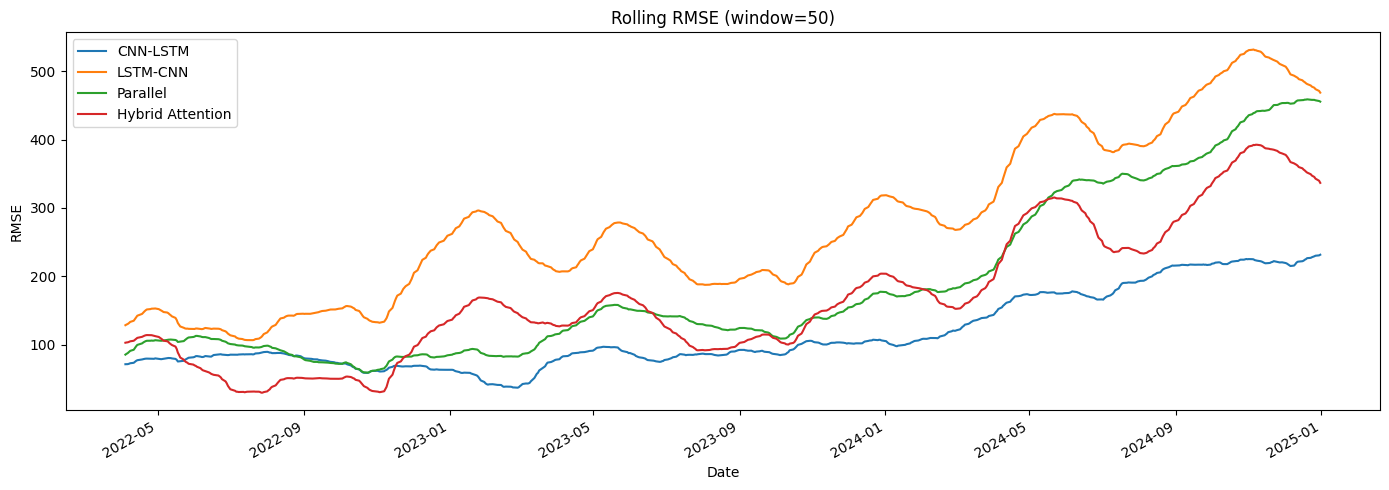

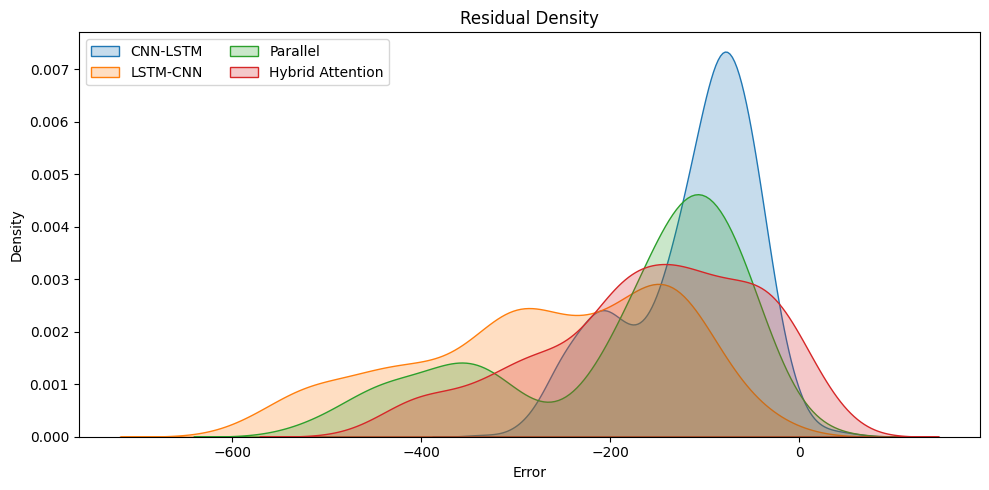

In [49]:
# 4. Rolling RMSE (model stability)
if 'preds_df' in globals():
    window_rmse = 50
    roll_metrics = {}
    model_cols = [c for c in preds_df.columns if c not in ['Actual']]
    for m in model_cols:
        se = (preds_df[m] - preds_df['Actual'])**2
        roll_metrics[m] = se.rolling(window_rmse).mean().pow(0.5)
    roll_df = pd.DataFrame(roll_metrics)
    plt.figure(figsize=(14,5))
    roll_df.plot(ax=plt.gca())
    plt.title(f'Rolling RMSE (window={window_rmse})')
    plt.ylabel('RMSE')
    plt.tight_layout()
    plt.show()
else:
    print('preds_df not found; run prediction cells first.')

# 5. Residual density (KDE)
if 'preds_df' in globals():
    plt.figure(figsize=(10,5))
    model_cols = [c for c in preds_df.columns if c not in ['Actual']]
    for m in model_cols:
        sns.kdeplot(preds_df[m]-preds_df['Actual'], label=m, fill=True, alpha=0.25)
    plt.title('Residual Density')
    plt.xlabel('Error')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()
else:
    print('preds_df not found; run prediction cells first.')

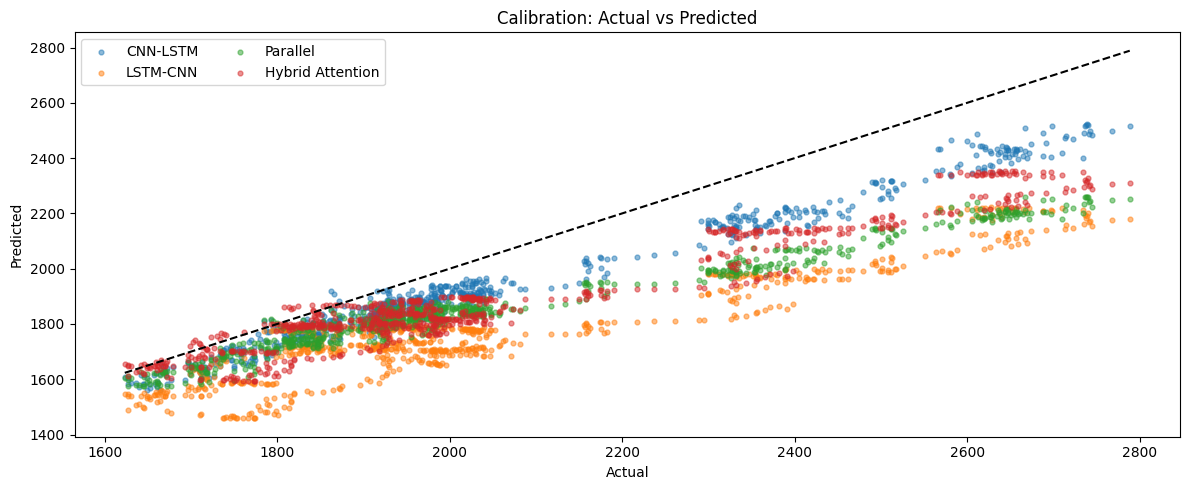

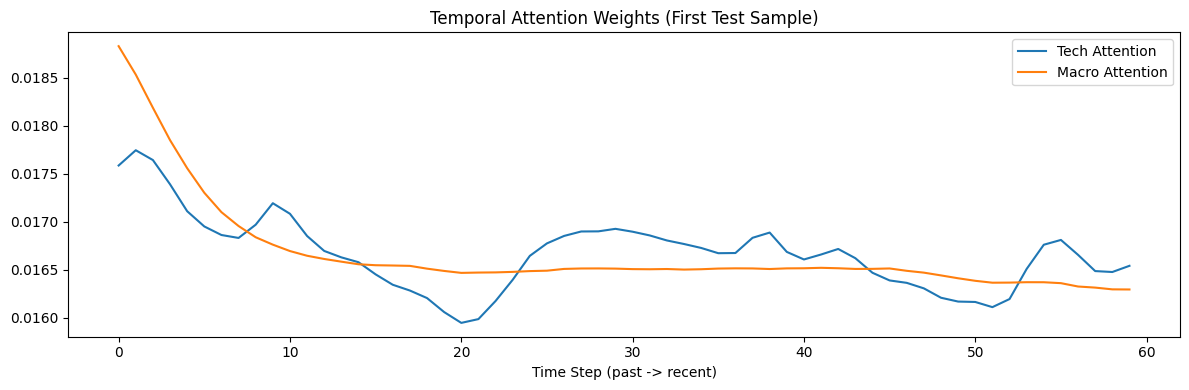

In [50]:
# 6. Calibration: Actual vs Predicted scatter
if 'preds_df' in globals():
    plt.figure(figsize=(12,5))
    model_cols = [c for c in preds_df.columns if c not in ['Actual']]
    for m in model_cols:
        plt.scatter(preds_df['Actual'], preds_df[m], s=12, alpha=0.5, label=m)
    lim = [preds_df['Actual'].min(), preds_df['Actual'].max()]
    plt.plot(lim, lim, 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Calibration: Actual vs Predicted')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()
else:
    print('preds_df not found; run prediction cells first.')

# 7. Attention weights (if hybrid attention model layers present)
try:
    attn_model = keras.Model(
        inputs=model_hybrid_attn.input,
        outputs=[
            model_hybrid_attn.get_layer('tech_attn_softmax').output,
            model_hybrid_attn.get_layer('macro_attn_softmax').output
        ]
    )
    tech_w, macro_w = attn_model.predict(X_test[:1], verbose=0)
    tech_w = tech_w.squeeze()
    macro_w = macro_w.squeeze()
    plt.figure(figsize=(12,4))
    plt.plot(tech_w, label='Tech Attention')
    plt.plot(macro_w, label='Macro Attention')
    plt.title('Temporal Attention Weights (First Test Sample)')
    plt.xlabel('Time Step (past -> recent)')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Attention visualization skipped:', e)

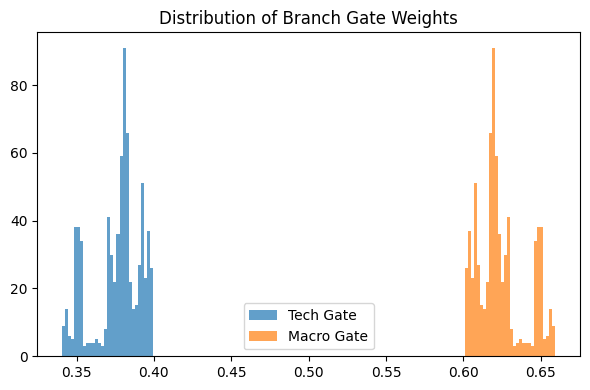

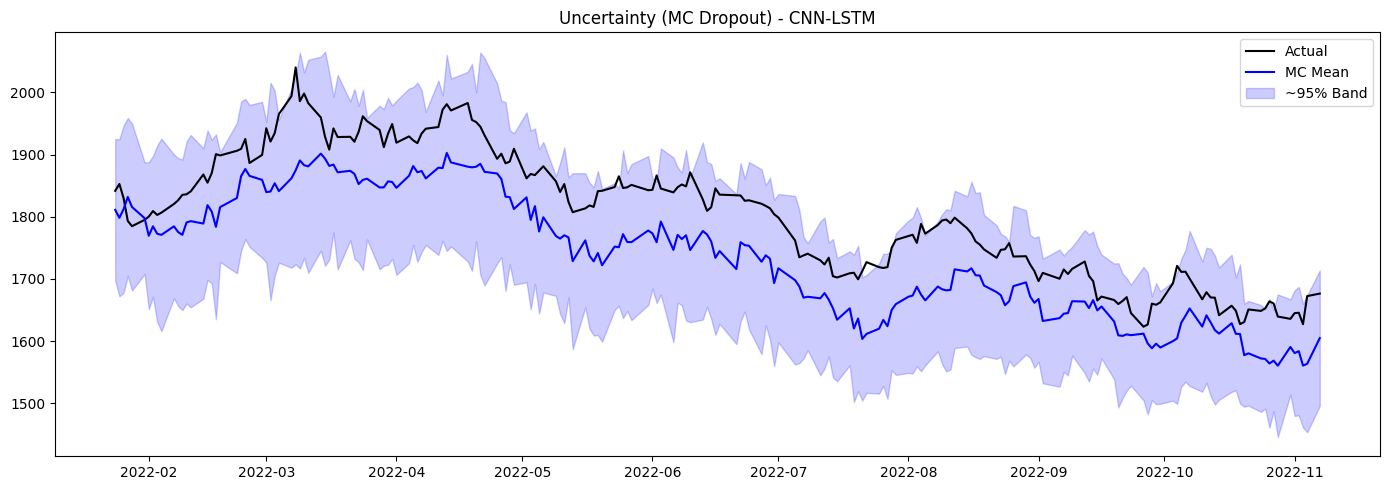

In [51]:
# 8. Branch gating weight distribution (if gate layer present)
try:
    gate_layer = keras.Model(
        inputs=model_hybrid_attn.input,
        outputs=model_hybrid_attn.get_layer('branch_gate').output
    )
    gates = gate_layer.predict(X_test, verbose=0)
    if gates.ndim == 2:
        plt.figure(figsize=(6,4))
        plt.hist(gates[:,0], bins=30, alpha=0.7, label='Tech Gate')
        plt.hist(gates[:,1], bins=30, alpha=0.7, label='Macro Gate')
        plt.title('Distribution of Branch Gate Weights')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print('Unexpected gate tensor shape:', gates.shape)
except Exception as e:
    print('Gate distribution skipped:', e)

# 9. Monte Carlo dropout uncertainty band (on first 200 test samples)
try:
    import numpy as np
    def mc_predict(mdl, X_in, runs=30):
        preds = []
        for _ in range(runs):
            preds.append(mdl(X_in, training=True).numpy().ravel())
        return np.vstack(preds)
    mc_n = min(200, X_test.shape[0])
    mc_scaled = mc_predict(model_cnn_lstm, X_test[:mc_n])
    mc_mean = mc_scaled.mean(axis=0)
    mc_std = mc_scaled.std(axis=0)
    # Assumes helper invert function exists: invert_scaled_vectors(mean_pred, y_true_slice, scalar, feature_col, target_index)
    inv_mean, inv_true = invert_scaled_vectors(mc_mean, y_test[:mc_n], scalar, feature_col, target_index)
    inv_low, _ = invert_scaled_vectors(mc_mean - 2*mc_std, y_test[:mc_n], scalar, feature_col, target_index)
    inv_high, _ = invert_scaled_vectors(mc_mean + 2*mc_std, y_test[:mc_n], scalar, feature_col, target_index)
    idx = test_target_index[:mc_n]
    plt.figure(figsize=(14,5))
    plt.plot(idx, inv_true, label='Actual', color='black')
    plt.plot(idx, inv_mean, label='MC Mean', color='blue')
    plt.fill_between(idx, inv_low, inv_high, color='blue', alpha=0.2, label='~95% Band')
    plt.title('Uncertainty (MC Dropout) - CNN-LSTM')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('MC Dropout visualization skipped:', e)